# This code estimates irrigation requirement for Soybean  using Penman-Monteith method

Note: Upward Flux equation used ET value from rainfed Corn tab of the spreadsheet. This value was not same as that of calculated ET.
The Flux value got similar results by changing the original ET from rainfed corn to ET = ETo* Kc.
However, we are ignroing the Flux, so it should be fine. 

Kc_Corn function needs to adjust accordingly if we want to include flux or not.

# 1. FAO Penman-Montieth method for estimating Ref. Evapotranspiration

In [1]:
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date

In [2]:
today = date.today().strftime("%Y-%m-%d")
# Get today's date as datetime
TDY = pd.Timestamp.today()
TWK = TDY.isocalendar().week
print('Today is :', today, '// Week:', TWK)

Today is : 2024-06-20 // Week: 25


In [3]:
def get_weather(filename, startdate):

    import urllib.request as req
    import os.path
    import json
    import requests
    import os
    import csv

    print('Getting Weather Data from Synoptic API')
    print('Data from :', startdate, '    to:', today)
    API_ROOT = "https://api.synopticdata.com/v2/stations/timeseries"
    API_TOKEN = "2e206cb80ead43a99afea07cb78908bb"
    STID='PDU01'
    startdate = startdate.strftime("%Y%m%d")+'1800'
    enddate = today+'1000'


    api_request_url = API_ROOT
    api_arguments = {"token":API_TOKEN,"stid":STID,"units":"english","obtimezone":"local", "start":startdate, "end":enddate, "timeformat":"%Y-%m-%d %H:%M"}
    req = requests.get(api_request_url, params=api_arguments)
    # ! Converting the data to a dictionary
    api_raw_data = req.json()

    print("===================== PLEASE CHECK THE UNITS BELOW =====================")
    for keys,values in api_raw_data['UNITS'].items():
        print(keys, ':', values)
    print("=========================================================================")
    
    # * Extracting the OBSERVATION data from the dictionary
    api_obs_data = api_raw_data['STATION'][0]['OBSERVATIONS']


    # * Writing the data to a CSV file
    with open(filename, "w", newline="\n") as f:
        # pass the csv file to csv.writer.
        writer = csv.writer(f, delimiter=',')
        
        # convert the dictionary keys to a list
        key_list = list(api_obs_data.keys())
        
        # find the length of the key_list
        limit = len(api_obs_data['date_time'])
        
        # the length of the keys corresponds to
        # no. of. columns.
        writer.writerow(api_obs_data.keys())
        
        # iterate each column and assign the
        # corresponding values to the column
        for i in range(limit):
            writer.writerow([api_obs_data[x][i] for x in key_list])



In [4]:
# only for reading the data as dataframe
# for reading 5-min data downloaded from MESONET
def read_hly_5min(file):
    indata = pd.read_csv(file, encoding='utf-16', sep='\t', header=1, parse_dates=[0], thousands=',',engine='python')
    indata = indata.drop(indata.columns[[-1, -2]],axis = 1)
    indata = indata.sort_values(by=['Time (LST)'])
    indata = indata.interpolate(method='linear', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')    
    headlist = indata.columns.values.tolist()

# for reading 30-min data downloaded from MESONET Synoptic API
def read_30min(file):
    indata = pd.read_csv(file, sep=',', parse_dates=[0], thousands=',', engine='python')
    # indata = indata.drop(indata.columns[[-1, -2]],axis = 1)
    
    # * Rename one columns
    # * Most of the column headers are having different name  from downloaded data from MESONET
    indata = indata.rename(columns={"date_time": "Time (LST)"})
    indata = indata.rename(columns={"air_temp_set_1": "Air Temp (°F)"})
    indata = indata.rename(columns={"relative_humidity_set_1": "Relative Humidity (%)"})
    indata = indata.rename(columns={"wind_speed_set_1": "Wind Speed (mph)"})
    indata = indata.rename(columns={"wind_gust_set_1": "Wind Gust (mph)"})
    indata = indata.rename(columns={"wind_direction_set_1": "Wind Dir (°)"})
    indata = indata.rename(columns={"pressure_set_1d": "Pressure (in)"})
    indata = indata.rename(columns={"solar_radiation_set_1": "Solar Radiation (W/m²)"})
    indata = indata.rename(columns={"precip_accum_30_minute_set_1": "Precipitation (in)"})

    indata = indata.sort_values(by=['Time (LST)'])
    indata = indata.interpolate(method='linear', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')

    
    headlist = indata.columns.values.tolist()

    return indata


def get_Mesonet():
    # * Using the downloaded data from MESONET (Daily data)
    filename = './Weather_for_Penman/03_Mesonet_data/Table (30-min).csv'
    # read the filename file and convert it to a dataframe
    indata = pd.read_csv(filename, header=1, encoding = "utf-16", sep='\t', thousands=',', parse_dates=[0], engine='python')
    # sort the dataframe by date
    indata = indata.sort_values(by='Time (LST)')
    indata = indata.rename(columns={"Time (LST)": "Time (LST)"})
    indata = indata.rename(columns={"Air Temp (°F)": "Air Temp (°F)"})
    indata = indata.rename(columns={"Relative Humidity (%)": "Relative Humidity (%)"})
    indata = indata.rename(columns={"Wind Speed (mph)": "Wind Speed (mph)"})
    indata = indata.rename(columns={"Wind Gust (mph)": "Wind Gust (mph)"})
    indata = indata.rename(columns={"Wind Direction (°)": "Wind Dir (°)"})
    # indata = indata.rename(columns={"pressure_set_1d": "Pressure (in)"})
    indata = indata.rename(columns={"Solar Radiation (W/m²)": "Solar Radiation (W/m²)"})
    indata = indata.rename(columns={"Precipitation (in)": "Precipitation (in)"})

    indata = indata.sort_values(by=['Time (LST)'])
    indata = indata.interpolate(method='linear', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')

    headlist = indata.columns.values.tolist()

    return indata

In [5]:
def subhly2dly(indata):
    # print(indata.info())

    ws_avg_dly = indata['Wind Speed (mph)'].resample('D').mean()   # wind speed
    ws_avg_dly = ws_avg_dly*0.44704  # convert to meter per second
    ws_avg_dly.rename('AVG_WS (mps)', inplace=True)

    pcpin_sum_dly = indata['Precipitation (in)'].resample('D').sum()   # solar radiation
    pcpin_sum_dly.rename('precip (in)', inplace=True)
    pcpmm_sum_dly = pcpin_sum_dly*25.4  # convert to mm
    pcpmm_sum_dly.rename('precip (mm)', inplace=True)

    rh_avg_dly = indata['Relative Humidity (%)'].resample('D').mean()   # relative humidity
    rh_avg_dly.rename('AVG_RH (%)', inplace=True)

    tf_avg_dly = indata['Air Temp (°F)'].resample('D').mean()   # average temperature
    tf_avg_dly.rename('AVG_Temp (°F)', inplace=True)
    tc_avg_dly = (tf_avg_dly-32)*5/9  # convert to celsius
    tc_avg_dly.rename('AVG_Temp (°C)', inplace=True)


    sr_avg_dly = indata['Solar Radiation (W/m²)'].resample('D').mean()   # solar radiation
    sr_avg_dly.rename('SUM_SR (W/m²)', inplace=True)

    # calculate saturation vapor pressure and vapor pressure
    def cal_svp(value):
        # formula for saturation vapor pressure
        # IF(Temp>0,0.6108*EXP(17.27*Temp/(237.3+Temp)),0.6108*EXP(17.27*0.5/(237.3+0.5)))
        if value > 0:
            return np.exp(17.27*value/(237.3+value))*0.6108
        else:
            return np.exp(17.27*0.5/(237.3+0.5))*0.6108
    svp_dly = tc_avg_dly.apply(cal_svp)  # saturation vapor pressure
    svp_dly.rename('SVP (kPa)', inplace=True)

    # get the vapor pressure from saturation vapor pressure and relative humidity
    vp_dly = rh_avg_dly/100*svp_dly*10  # vapor pressure
    vp_dly.rename('VP (mb)', inplace=True)

    # combine all the data and build the daily data
    dlydata = pd.concat([ws_avg_dly, pcpmm_sum_dly, sr_avg_dly, tc_avg_dly, rh_avg_dly, svp_dly, vp_dly], axis=1)

    # update the SVP based on the VP and temperature in the daily data
    def update_svp(VP, Temp):
        # formula for updating saturation vapor pressure
        # =IF(Temp>0,0.6108*EXP(17.27*Temp/(237.3+Temp)),VP*0.1)
        if Temp > 0:
            return np.exp(17.27*Temp/(237.3+Temp))*0.6108
        else:
            return VP*0.1

    # update the SVP based on the previous day's VP and temperature
    for i, row in dlydata.iterrows():
        dlydata.at[i, 'SVP (kPa)'] = update_svp(dlydata.at[i, 'VP (mb)'], row['AVG_Temp (°C)'])


    # save the data
    dlydata = dlydata.round(4)
    outfilename = './Weather_for_Penman/01_Clean_Weather_data/Daily_weather_'+today+'_.csv'
    dlydata.to_csv(outfilename) 


    return dlydata


In [6]:
## * Main Code Block
# indata = read_hly('Table (5-min).csv')
filename = "./Weather_for_Penman/02_API_Weather_data/API_Weather_"+today+".csv"
# get the weather data from the earlier date between CED and SED

# ! =================================================
# ! conduct penman-montieth model                   =
# ! =================================================
# Calculate the potential evapotranspiration (ETo) using Penman-Monteith model
# * 1. get the 30 min weather data from API and aggregate to hourly data
# raw input the weather data method by user, if 1, run get_weather, if 2 use the data from the root directory
method = input("Enter the method to get the weather data.\n_______ 1) API.\n_______ 2) Downloaded Mesonet data: ")

# * 1.1. User will choose the method to get the weather data
# * 1) Download the weather data from the API
# * 2) Use the Mesonet data downloaded manually from the website and should be located in the 03_Mesonet_data folder
if method == '1':
    print ('Downloading the weather data from the API')
    get_weather(filename, min(CED, SED))
    indata = read_30min(filename)
elif method == '2':
    print ('Using the Mesonet data')
    indata = get_Mesonet()


# TODO : check the data for the missing values 2024-06-18
dlydata = subhly2dly(indata)


# save the data
dlydata = dlydata.round(4)
# outfilename = './Penman_irrigation_results.csv'
# dlydata.to_csv(outfilename, encoding = "utf-16", sep='\t')
# dlydata.to_excel(outfilename.replace('.csv','.xlsx'), sheet_name='Penman_irrigation_results', freeze_panes=(1,1))

dlydata.tail()

Enter the method to get the weather data.
_______ 1) API.
_______ 2) Downloaded Mesonet data:  2


Using the Mesonet data


C:\Users\tbijoych\AppData\Local\Temp\ipykernel_2892\3561962693.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  indata = pd.read_csv(filename, header=1, encoding = "utf-16", sep='\t', thousands=',', parse_dates=[0], engine='python')


,AVG_WS (mps),precip (mm),SUM_SR (W/m²),AVG_Temp (°C),AVG_RH (%),SVP (kPa),VP (mb)
Time (LST),,,,,,,
2024-06-13,3.9079,14.478,351.8750,25.4560,54.3542,3.2548,17.6915
2024-06-14,2.1924,4.572,381.7083,23.9074,66.7917,2.9674,19.8196
2024-06-15,2.1952,0.000,357.6250,23.2269,55.9792,2.8482,15.9441
2024-06-16,3.3779,0.000,356.2708,26.6921,51.0625,3.5014,17.8793
2024-06-17,2.8417,0.000,382.6000,27.6037,69.1667,3.6936,25.5473


In [7]:
dlydata = dlydata.reset_index()
dlydata.columns = ['Date','Wind Speed','Precipitation','Solar Radiation','Air Temperature','RH','SVP','Vapor Pressure']
dlydata.head(2)

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,RH,SVP,Vapor Pressure
0,2024-04-01,4.4856,16.510,59.9787,9.6608,92.4468,1.2003,11.0966
1,2024-04-02,5.1167,25.146,88.9167,10.4653,90.4583,1.2668,11.4591


In [8]:
df = dlydata.drop(['RH','SVP'], axis=1)
df["month1"]=df["Date"].dt.month
df.head(3)

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,Vapor Pressure,month1
0,2024-04-01,4.4856,16.510,59.9787,9.6608,11.0966,4
1,2024-04-02,5.1167,25.146,88.9167,10.4653,11.4591,4
2,2024-04-03,6.7959,4.064,112.6667,2.8403,6.5198,4


In [9]:
data = {'month1': np.arange(1,13),
        'Temp_avg': [-3.150,-1.345,4.547,11.109,17.016,21.745,22.969,21.738,18.330,11.936,5.572,-0.620]}
 
# Create DataFrame
df2 = pd.DataFrame(data)
df2.head()

,month1,Temp_avg
0,1,-3.150
1,2,-1.345
2,3,4.547
3,4,11.109
4,5,17.016


In [10]:
# Create a new column and calculate its values using if-else conditions
df2['heat_Flux'] = 0.07 * np.where(df2['month1'] == 1, 
                                    df2['Temp_avg'].shift(-1) - df2['Temp_avg'].iloc[-1],
                                    np.where(df2['month1'] == 12,
                                             df2['Temp_avg'].iloc[0] - df2['Temp_avg'].shift(1),
                                             df2['Temp_avg'].shift(-1) - df2['Temp_avg'].shift(1)))
df=pd.merge(df, df2, left_on='month1', right_on='month1')
df

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,Vapor Pressure,month1,Temp_avg,heat_Flux
0,2024-04-01,4.4856,16.510,59.9787,9.6608,11.0966,4,11.109,0.87283
1,2024-04-02,5.1167,25.146,88.9167,10.4653,11.4591,4,11.109,0.87283
2,2024-04-03,6.7959,4.064,112.6667,2.8403,6.5198,4,11.109,0.87283
3,2024-04-04,5.7482,3.556,71.5833,3.4375,6.8310,4,11.109,0.87283
4,2024-04-05,4.3335,0.000,151.0208,4.7951,6.6966,4,11.109,0.87283
...,...,...,...,...,...,...,...,...,...
73,2024-06-13,3.9079,14.478,351.8750,25.4560,17.6915,6,21.745,0.41671
74,2024-06-14,2.1924,4.572,381.7083,23.9074,19.8196,6,21.745,0.41671
75,2024-06-15,2.1952,0.000,357.6250,23.2269,15.9441,6,21.745,0.41671
76,2024-06-16,3.3779,0.000,356.2708,26.6921,17.8793,6,21.745,0.41671


In [11]:
df["year"]=df["Date"].dt.year
df['month'] = 1
df['day'] = 1
df['J_Date']=pd.to_datetime(df[["year", "month", "day"]])
df['j']=df['Date'].apply(pd.Timestamp.to_julian_date)-df['J_Date'].apply(pd.Timestamp.to_julian_date)+1
df.head()

,Date,Wind Speed,Precipitation,Solar Radiation,Air Temperature,Vapor Pressure,month1,Temp_avg,heat_Flux,year,month,day,J_Date,j
0,2024-04-01,4.4856,16.510,59.9787,9.6608,11.0966,4,11.109,0.87283,2024,1,1,2024-01-01,92.0
1,2024-04-02,5.1167,25.146,88.9167,10.4653,11.4591,4,11.109,0.87283,2024,1,1,2024-01-01,93.0
2,2024-04-03,6.7959,4.064,112.6667,2.8403,6.5198,4,11.109,0.87283,2024,1,1,2024-01-01,94.0
3,2024-04-04,5.7482,3.556,71.5833,3.4375,6.8310,4,11.109,0.87283,2024,1,1,2024-01-01,95.0
4,2024-04-05,4.3335,0.000,151.0208,4.7951,6.6966,4,11.109,0.87283,2024,1,1,2024-01-01,96.0


In [12]:
df = df.rename(columns={'Solar Radiation':'radiation','Air Temperature':"Temp",'Wind Speed':'Wind_speed','Vapor Pressure':'V_Pressure'})

#df=df.iloc[0:10,:]
df

,Date,Wind_speed,Precipitation,radiation,Temp,V_Pressure,month1,Temp_avg,heat_Flux,year,month,day,J_Date,j
0,2024-04-01,4.4856,16.510,59.9787,9.6608,11.0966,4,11.109,0.87283,2024,1,1,2024-01-01,92.0
1,2024-04-02,5.1167,25.146,88.9167,10.4653,11.4591,4,11.109,0.87283,2024,1,1,2024-01-01,93.0
2,2024-04-03,6.7959,4.064,112.6667,2.8403,6.5198,4,11.109,0.87283,2024,1,1,2024-01-01,94.0
3,2024-04-04,5.7482,3.556,71.5833,3.4375,6.8310,4,11.109,0.87283,2024,1,1,2024-01-01,95.0
4,2024-04-05,4.3335,0.000,151.0208,4.7951,6.6966,4,11.109,0.87283,2024,1,1,2024-01-01,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2024-06-13,3.9079,14.478,351.8750,25.4560,17.6915,6,21.745,0.41671,2024,1,1,2024-01-01,165.0
74,2024-06-14,2.1924,4.572,381.7083,23.9074,19.8196,6,21.745,0.41671,2024,1,1,2024-01-01,166.0
75,2024-06-15,2.1952,0.000,357.6250,23.2269,15.9441,6,21.745,0.41671,2024,1,1,2024-01-01,167.0
76,2024-06-16,3.3779,0.000,356.2708,26.6921,17.8793,6,21.745,0.41671,2024,1,1,2024-01-01,168.0


In [13]:
def PET_Penman (Wind_speed, radiation, Temp, V_Pressure, heat_Flux, j):
    lammbda= 2.501-Temp*0.002361 
     
    if Temp > 0:
        Sat_VP = 0.6108 * math.exp(17.27 * Temp / (237.3 + Temp))
    else:
        Sat_VP = V_Pressure * 0.1
        
    vpd= Sat_VP-V_Pressure*0.1
    slope= 4098*0.6108*math.exp(((17.27*Temp)/(Temp+237.3)))/((Temp+237.3)**2)
    
    Pressure= 101.3*((293-0.0065*213.36)/293)**5.26
    gamma  =0.001013*Pressure/(0.622*lammbda)
    sigma=4.903*10**-9
    
    Rbo= sigma*(Temp+273)**4
    Rs= radiation*60*60*24/10e5    
    dr=1+0.033*math.cos(2*math.pi*j/365)
    declination=0.409*math.sin((2*math.pi*j/365)-1.39)
    sunset_angle=math.acos(-1*math.tan(40.469794*math.pi/180)*math.tan(declination))
    Ra=(24*60*0.082/math.pi)*dr*(math.sin(40.469794*math.pi/180)*math.sin(declination)+math.cos(40.469794*math.pi/180)*math.cos(declination)*math.sin(sunset_angle))
    Rso=(213.36*0.00002+0.75)*Ra    
    Rnl=Rbo*(0.34-0.14*math.sqrt(0.1*V_Pressure))*(1.35*(Rs/Rso) - 0.35)      
    Rnet=Rs*(1-0.23)-Rnl
    ETo=(0.408*slope*(Rnet-heat_Flux)+gamma*(900/(Temp+273))*Wind_speed*vpd)/(slope+gamma*(1+0.34*Wind_speed))  
    ETo_in=ETo/25.4
    #return (lammbda,Sat_VP,vpd,slope,Pressure,gamma,sigma,Rbo,Rs,j,dr,declination,sunset_angle,Ra, Rso,Rnl,ETo)
    return ETo, ETo_in


In [14]:
#df['ETo'] = df.apply(lambda row: PET(row['Wind_speed'], row['heat_Flux'], row['radiation'], row['Temp'], row['V_Pressure'],row['j']), axis=1)

# zip allows for multiple columns
%timeit df['ETo_mmDay'], df['ETo_in'] = zip(*df.apply(lambda row: PET_Penman(row['Wind_speed'], row['radiation'], row['Temp'], row['V_Pressure'], row['heat_Flux'],row['j']), axis=1))

#df.ETo_in=df.ETo_in.round(3)
df

2.5 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Date,Wind_speed,Precipitation,radiation,Temp,V_Pressure,month1,Temp_avg,heat_Flux,year,month,day,J_Date,j,ETo_mmDay,ETo_in
0,2024-04-01,4.4856,16.510,59.9787,9.6608,11.0966,4,11.109,0.87283,2024,1,1,2024-01-01,92.0,0.799067,0.031459
1,2024-04-02,5.1167,25.146,88.9167,10.4653,11.4591,4,11.109,0.87283,2024,1,1,2024-01-01,93.0,1.068362,0.042061
2,2024-04-03,6.7959,4.064,112.6667,2.8403,6.5198,4,11.109,0.87283,2024,1,1,2024-01-01,94.0,0.945322,0.037217
3,2024-04-04,5.7482,3.556,71.5833,3.4375,6.8310,4,11.109,0.87283,2024,1,1,2024-01-01,95.0,0.834214,0.032843
4,2024-04-05,4.3335,0.000,151.0208,4.7951,6.6966,4,11.109,0.87283,2024,1,1,2024-01-01,96.0,1.508454,0.059388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2024-06-13,3.9079,14.478,351.8750,25.4560,17.6915,6,21.745,0.41671,2024,1,1,2024-01-01,165.0,6.789541,0.267305
74,2024-06-14,2.1924,4.572,381.7083,23.9074,19.8196,6,21.745,0.41671,2024,1,1,2024-01-01,166.0,5.723294,0.225327
75,2024-06-15,2.1952,0.000,357.6250,23.2269,15.9441,6,21.745,0.41671,2024,1,1,2024-01-01,167.0,5.636144,0.221895
76,2024-06-16,3.3779,0.000,356.2708,26.6921,17.8793,6,21.745,0.41671,2024,1,1,2024-01-01,168.0,6.997671,0.275499


## The Ref ET estimated using Penman-Monteith:

In [15]:
#df.loc[(df.Date >= '2023-08-30') & (df.Date <= '2023-09-10')]
#df=df[['Date','Wind_speed','Precipitation','radiation','Temp','V_Pressure','ETo_mmDay','ETo_in']]
df=df[['Date','Precipitation','ETo_in']]
df['Precipitation']=df['Precipitation']/25.4
df

C:\Users\tbijoych\AppData\Local\Temp\ipykernel_2892\801641425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Precipitation']=df['Precipitation']/25.4


,Date,Precipitation,ETo_in
0,2024-04-01,0.65,0.031459
1,2024-04-02,0.99,0.042061
2,2024-04-03,0.16,0.037217
3,2024-04-04,0.14,0.032843
4,2024-04-05,0.00,0.059388
...,...,...,...
73,2024-06-13,0.57,0.267305
74,2024-06-14,0.18,0.225327
75,2024-06-15,0.00,0.221895
76,2024-06-16,0.00,0.275499


# 2. Crop Coefficent: Soybean 

In [16]:
df_Soybean = pd.read_excel('../Irrigation_Scheduling_Field70_2023.xlsx', 'Soy Irr', skiprows=6)
df_Soybean=df_Soybean.iloc[1:168, : 26] 
df_Soybean['Date']=pd.to_datetime(df_Soybean['Date']).dt.date
df_Soybean['Date'] = pd.to_datetime(df_Soybean['Date'])
#df_Soybean.columns
df_Soybean.head()

,Date,Week\nPast\nEmer-gence\n(WPE),Penman Eto,Kc,Unstressed Crop ET,Irrigation Length,Crop ET\n(ET),Effective Rain\n®,Shallow grondwater cont. (UF),Effective Irrigation\n(I),...,Total\nET,Total\nRain,Total\nIrrigation,Total\nWater Losses,Notes,Depth to wtable (m),0-6 in,6 - 12 in,12 - 18 in,18 - 24 in
1,2023-05-01,0,0.038428,0.2,0.007686,0,0.007686,0.23,0.00451,NaN,...,0.007686,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
2,2023-05-02,0,0.049236,0.2,0.009847,0,0.009847,0,0.005779,NaN,...,0.017533,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
3,2023-05-03,0,0.114062,0.2,0.022812,0,0.022812,0,0.013387,NaN,...,0.040345,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
4,2023-05-04,0,0.180663,0.2,0.036133,0,0.036133,0,0.021204,NaN,...,0.076478,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333
5,2023-05-05,0,0.184206,0.2,0.036841,0,0.036841,0,0.02162,NaN,...,0.113319,0.23,0,0,NaN,1.2,0.195333,0.293667,0.366333,0.397333


In [17]:
start_date = '2024-04-01'
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=len(df_Soybean))
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
dt=pd.DataFrame(date_range, columns=['Date'])

In [18]:
df_Soybean['Date'] = dt['Date']
df_Kc=df_Soybean[['Date','Soil-Water Deficit Percent (Adjusted)\n(SWDPadj)','Effective Irrigation\n(I)','Depth to wtable (m)', '0-6 in', '6 - 12 in', '12 - 18 in',
       '18 - 24 in']]
#df_Kc = df_Kc.rename(columns={'Week\nPast\nEmer-gence\n(WPE)':'WPE','Soil-Water Deficit Percent\n(SWDP)':'SWDP'})
df_Kc = df_Kc.rename(columns={'Soil-Water Deficit Percent (Adjusted)\n(SWDPadj)':'SWDPadj','Effective Irrigation\n(I)':'eff_irr',
                             'Depth to wtable (m)':'WTable', '0-6 in':"WT0_6in",'6 - 12 in':"WT6_12in",'12 - 18 in':"WT12_18in",'18 - 24 in':"WT18_24in"})
df_Kc['SWDPadj'] = df_Kc['SWDPadj'].fillna('a') ## --- >>>> User defined data

df_Kc['WTable']=df_Kc['WTable'].fillna(1.3)
df_Kc=df_Kc.fillna(0)
df_Kc['Date']=pd.to_datetime(df_Kc['Date']).dt.date
df_Kc['Date'] = pd.to_datetime(df_Kc['Date'])
df_Kc.head()

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in
1,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333
2,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
3,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
4,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333
5,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333


In [19]:
Emergence = pd.to_datetime(["5/21/2024"]) # actual date is 5/13/2023 & date are in mm-dd-yy 23:59 format. This enable to get actual RZ value
Harvest = pd.to_datetime(["09/10/2024"])
Harvest


DatetimeIndex(['2024-09-10'], dtype='datetime64[ns]', freq=None)

In [20]:
def calculate_WPE(date):
    if date < Emergence:
        return 0
    elif date > Harvest:
        return 0
    else:
        return ((((date-Emergence).days)/7).astype(int)+1)[0]

df_Kc['WPE']=df_Kc['Date'].apply(calculate_WPE)
df_Kc.iloc[160:,]

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE
161,2024-09-09,a,0.0,1.3,0.0,0.0,0.0,0.0,16
162,2024-09-10,a,0.0,1.3,0.0,0.0,0.0,0.0,17
163,2024-09-11,a,0.0,1.3,0.0,0.0,0.0,0.0,0
164,2024-09-12,a,0.0,1.3,0.0,0.0,0.0,0.0,0
165,2024-09-13,a,0.0,1.3,0.0,0.0,0.0,0.0,0
166,2024-09-14,a,0.0,1.3,0.0,0.0,0.0,0.0,0
167,2024-09-15,a,0.0,1.3,0.0,0.0,0.0,0.0,0


## 2.1 Average Weekly crop coefficient for Soybean in Indiana

In [21]:
Soybean_Kc_Indiana= {'Tmax_F': [1] * 22 ,
    'WPE': np.arange(1,23),
        'Kc_avg': [0.138, 0.181, 0.2367, 0.29667, 0.36333, 0.4533, 0.5589, 0.6511, 0.74, 0.8233, 0.9044, 0.9767, 0.9978, 0.9422, 0.87, 0.7867, 0.7211, 0.66, 0.1, 0.1, 0.1, 0.1]}

Soybean_Kc_Indiana = pd.DataFrame(Soybean_Kc_Indiana)
#Corn_Kc_Indiana["new"]= Corn_Kc_Indiana['Kc_avg'].shift(1)# delete it
Soybean_Kc_Indiana

,Tmax_F,WPE,Kc_avg
0,1,1,0.13800
1,1,2,0.18100
2,1,3,0.23670
3,1,4,0.29667
4,1,5,0.36333
5,1,6,0.45330
6,1,7,0.55890
7,1,8,0.65110
8,1,9,0.74000
9,1,10,0.82330


In [22]:
df_Kc=df_Kc.merge(Soybean_Kc_Indiana, on='WPE', how='left')
df_Kc = df_Kc.drop('Tmax_F', axis=1)
df_Kc['Kc_avg'] = df_Kc['Kc_avg'].fillna(0)
df_Kc

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg
0,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
1,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
2,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
3,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
4,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0
...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
163,2024-09-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
164,2024-09-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0
165,2024-09-14,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0


# 3. Merge Penman Monteith ETo and Soybean weekly Kc

In [23]:
dat=df_Kc.merge(df, on='Date', how='left')
dat=dat.rename(columns={'Precipitation':'Eff_Rain'})
#dat=dat.iloc[0:130] # to reomve nan rows   
dat['Eff_Rain'] = dat['Eff_Rain'].fillna(0)
dat

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,Eff_Rain,ETo_in
0,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.99,0.042061
1,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.16,0.037217
2,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.14,0.032843
3,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.059388
4,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.100235
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
163,2024-09-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
164,2024-09-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
165,2024-09-14,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN


In [24]:
if dat.index.max() > 129:   
    dat.loc[dat.index > 129, 'ETo_in'] = dat.iloc[129]['ETo_in']
dat   

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,Eff_Rain,ETo_in
0,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.99,0.042061
1,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.16,0.037217
2,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.14,0.032843
3,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.059388
4,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.100235
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
163,2024-09-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
164,2024-09-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN
165,2024-09-14,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN


In [25]:
WA_rate = 0.045632799 # water applicationr ate (in/hr)- ned to calculate
RZinitial=4
RZMD=24  # Root Zone Maximum Depth (in)
W_RZMD=7 # week of RZMD
#Emergence = pd.to_datetime(["/15/2023"]) # actual date is 5/16/2023 & date are in mm-dd-yy 23:59 format. This enable to get actual RZ value

In [26]:
# check spreadsheet how RZ max is 24. Therefore, i use a if condition for rz>24, rz=24
def RZ_all (Date, WPE):
    
    if Date <= Emergence:
        RZ=RZinitial
    elif Date > Harvest:
        RZ=RZinitial
    elif Date > Emergence and WPE < W_RZMD:
        RZ= RZ_previous_step + (RZMD - RZinitial) / ((W_RZMD- 1) * 7)
    else:
        RZ=RZMD
    
    if RZ>24:
        RZ=24
    else:
        RZ=RZ
        
    return RZ   

for index, row in dat.iterrows():
    RZ = RZ_all(row['Date'], row['WPE'])
    # if index==1:
    #     RZ_previous_step=4
    # else:
    #     RZ_previous_step = RZ    
    RZ_previous_step = RZ   
    
    dat.at[index, 'RZ'] = RZ
    
#df_Kc.iloc[51:70]

In [27]:
Soil_table = pd.DataFrame({
    'Layer': np.arange(0,8),
    'From': [0,0,6,12,18,24,48,48],
    'To': [0,6,12,18,24,48,48,48],
    'Thickness': [0,6,6,6,6,0,0,0],
    'AWHC': [0,0.23,0.23,0.21,0.2,0,0,0]})


Soil_table['AWHCj']=Soil_table['Thickness']*Soil_table['AWHC']
Soil_table['AWHCj_cum']=Soil_table['AWHCj'].cumsum()
Soil_table1=Soil_table[['To','AWHCj_cum']]

In [28]:
def AWHCrz_func(rz):    
    if rz in Soil_table1['To'].values:
        i = Soil_table1.index[Soil_table1['To'] == rz][0]
        dfx = Soil_table1.iloc[i:i+2]
    else:
        Soil_table1["To"] > rz
        v = Soil_table1["To"] > rz 
        i = v[v].index[0]   
        dfx = Soil_table1.iloc[i-1:i+1]
      
    
    AWHCrz= ((rz-dfx.iloc[0][0])/(dfx.iloc[1][0]-dfx.iloc[0][0]))* (dfx.iloc[1][1]-dfx.iloc[0][1])+dfx.iloc[0][1]        
            
    return AWHCrz

dat['AWHCrz'] = dat.apply(lambda x: AWHCrz_func(x['RZ']), axis=1)

dat

,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,Eff_Rain,ETo_in,RZ,AWHCrz
0,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.99,0.042061,4.0,0.92
1,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.16,0.037217,4.0,0.92
2,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.14,0.032843,4.0,0.92
3,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.059388,4.0,0.92
4,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,0.00,0.100235,4.0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN,4.0,0.92
163,2024-09-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN,4.0,0.92
164,2024-09-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN,4.0,0.92
165,2024-09-14,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,0.00,NaN,4.0,0.92


In [29]:
SWDPcritical=0.7 #SWD (%) level beyond which ET is reduced due to drought stress
SWDP_1=0
SWD_1=0
#WL=0
thetaS= 26.04
thetaR= 4.28
Ds = 0.3
Dd = 1.3
k=1
def Kc_Corn (Date, WPE, Kc_avg, ETo_in, AWHCrz, Eff_Rain, eff_irr, SWDPadj, WTable, WT0_6in, WT6_12in, WT12_18in, WT18_24in):
          
    # if WPE > 0:
    #     if SWDP_1 <= SWDPcritical:
    #         Kc=1
    #     else:
    #         Kc=Kc_avg #Kc=((1-SWDP_1)/(1-SWDPcritical))*Kc_avg --? this is the equation but used same table of kc avergae
    # else:
    #     Kc=0.2
     
    if WPE == 0:
        Kc=0.2
    else:
        Kc=Kc_avg 
        
    unstressed_ET=Kc*ETo_in   
    ET=Kc*ETo_in        
    
  
      
    # UFlux#
    SM_60=6*(WT0_6in+WT6_12in+WT12_18in+WT18_24in)
    
    if SM_60>0:
        rel_SM=(SM_60-thetaR)/(thetaS-thetaR)
    else:
        rel_SM=0    
    rel_WT= (Ds-WTable)/(Ds-Dd) 
    
    if rel_SM > 0:        
        multiplier= (1-rel_WT)**(k*math.sin(rel_SM*(math.pi/2)))
    else:       
        multiplier= (1-rel_WT)**(k*math.sin(1*(math.pi/2)))
        
    if WTable<Ds:
        U_Flux= ET
    elif WTable >Dd:
        U_Flux= 0
    else:
        U_Flux= ET*multiplier
    

    ##############
    if index == 0:
        WL=0
    elif (SWD_1+ET-Eff_Rain-eff_irr) < 0:
        WL= -SWD_1-ET+Eff_Rain+eff_irr # with flux WL= -SWD_1-ET+Eff_Rain+eff_irr+U_Flux 
    else:
        WL=0  
        
    if index==0:
        SWD=0
    elif SWDPadj != 'a':
        SWD = SWDPadj * AWHCrz
    else:        
        SWD = SWD_1+ET+WL-Eff_Rain-eff_irr # with flux,  SWD = SWD_1+ET+WL-Eff_Rain-eff_irr-U_Flux
    
    
    if index==0:
        SWDP=0
    else:
        SWDP=SWD/AWHCrz
    
    
    if SWDP_1 > 0.3:
        Irr_len= ET/WA_rate
    else:
        Irr_len=0       
  
        
        
    OUTPUT=(WL, ET,   Kc, Irr_len, U_Flux, SWD,  SWDP) 
    return OUTPUT




In [30]:
for index, i in dat.iterrows():
   
    OUT = Kc_Corn( i['Date'], i['WPE'], i['Kc_avg'], i['ETo_in'], i['AWHCrz'],i['Eff_Rain'], i['eff_irr'],i['SWDPadj'], i['WTable'], i['WT0_6in'], i['WT6_12in'], i['WT12_18in'], i['WT18_24in'])    
            
    SWD_1 = OUT[5]  
    #SWDP_1 = OUT[5]   
    
    OUT = pd.DataFrame(OUT)
    OUT=OUT.T
    OUT.columns = ["WL", "ET",'Kc','Irr_len','U_Flux','SWD','SWDP']  
   
   
    dat.at[index, 'WL'] = OUT['WL'].iloc[0]      
    dat.at[index, 'ET'] = OUT['ET'].iloc[0]
    dat.at[index, 'Kc'] = OUT['Kc'].iloc[0]
    dat.at[index, 'Irr_len'] = OUT['Irr_len'].iloc[0]
    dat.at[index, 'U_Flux'] = OUT['U_Flux'].iloc[0]    
    dat.at[index, 'SWD'] = OUT['SWD'].iloc[0]
    dat.at[index, 'SWDP'] = OUT['SWDP'].iloc[0]
dat



,Date,SWDPadj,eff_irr,WTable,WT0_6in,WT6_12in,WT12_18in,WT18_24in,WPE,Kc_avg,...,ETo_in,RZ,AWHCrz,WL,ET,Kc,Irr_len,U_Flux,SWD,SWDP
0,2024-04-02,0,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.042061,4.0,0.92,0.000000,0.008412,0.2,0.0,0.004937,0.000000,0.000000
1,2024-04-03,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.037217,4.0,0.92,0.152557,0.007443,0.2,0.0,0.004368,0.000000,0.000000
2,2024-04-04,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.032843,4.0,0.92,0.133431,0.006569,0.2,0.0,0.003855,0.000000,0.000000
3,2024-04-05,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.059388,4.0,0.92,0.000000,0.011878,0.2,0.0,0.006970,0.011878,0.012910
4,2024-04-06,a,0.0,1.2,0.195333,0.293667,0.366333,0.397333,0,0.0,...,0.100235,4.0,0.92,0.000000,0.020047,0.2,0.0,0.011764,0.031925,0.034701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,NaN,4.0,0.92,0.000000,NaN,0.2,0.0,NaN,NaN,NaN
163,2024-09-12,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,NaN,4.0,0.92,0.000000,NaN,0.2,0.0,NaN,NaN,NaN
164,2024-09-13,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,NaN,4.0,0.92,0.000000,NaN,0.2,0.0,NaN,NaN,NaN
165,2024-09-14,a,0.0,1.3,0.000000,0.000000,0.000000,0.000000,0,0.0,...,NaN,4.0,0.92,0.000000,NaN,0.2,0.0,NaN,NaN,NaN


In [31]:
dat=dat[['Date', 'WPE','ETo_in','Kc','Irr_len','ET','Eff_Rain', 'U_Flux','eff_irr','SWD', 'SWDP','SWDPadj', 'WL', 'RZ', 'AWHCrz']]
dat.tail()

,Date,WPE,ETo_in,Kc,Irr_len,ET,Eff_Rain,U_Flux,eff_irr,SWD,SWDP,SWDPadj,WL,RZ,AWHCrz
162,2024-09-11,0,NaN,0.2,0.0,NaN,0.0,NaN,0.0,NaN,NaN,a,0.0,4.0,0.92
163,2024-09-12,0,NaN,0.2,0.0,NaN,0.0,NaN,0.0,NaN,NaN,a,0.0,4.0,0.92
164,2024-09-13,0,NaN,0.2,0.0,NaN,0.0,NaN,0.0,NaN,NaN,a,0.0,4.0,0.92
165,2024-09-14,0,NaN,0.2,0.0,NaN,0.0,NaN,0.0,NaN,NaN,a,0.0,4.0,0.92
166,2024-09-15,0,NaN,0.2,0.0,NaN,0.0,NaN,0.0,NaN,NaN,a,0.0,4.0,0.92


In [32]:
dat.loc[:, 'Total_ET'] = dat['ET'].cumsum()
dat.loc[:, 'Total_Rain'] = dat['Eff_Rain'].cumsum()
dat.loc[:, 'Total_Irr'] = dat['eff_irr'].cumsum()
dat.loc[:, 'Total_WL'] = dat['WL'].cumsum()
dat
#dat_check=dat.merge(df_Soy_ref, how='left', on='Date')
#dat_check.to_csv('../out_soybean.csv', index=True) 

C:\Users\tbijoych\AppData\Local\Temp\ipykernel_2892\3641335574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:, 'Total_ET'] = dat['ET'].cumsum()
C:\Users\tbijoych\AppData\Local\Temp\ipykernel_2892\3641335574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:, 'Total_Rain'] = dat['Eff_Rain'].cumsum()
C:\Users\tbijoych\AppData\Local\Temp\ipykernel_2892\3641335574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Date,WPE,ETo_in,Kc,Irr_len,ET,Eff_Rain,U_Flux,eff_irr,SWD,SWDP,SWDPadj,WL,RZ,AWHCrz,Total_ET,Total_Rain,Total_Irr,Total_WL
0,2024-04-02,0,0.042061,0.2,0.0,0.008412,0.99,0.004937,0.0,0.000000,0.000000,0,0.000000,4.0,0.92,0.008412,0.99,0.0000,0.000000
1,2024-04-03,0,0.037217,0.2,0.0,0.007443,0.16,0.004368,0.0,0.000000,0.000000,a,0.152557,4.0,0.92,0.015856,1.15,0.0000,0.152557
2,2024-04-04,0,0.032843,0.2,0.0,0.006569,0.14,0.003855,0.0,0.000000,0.000000,a,0.133431,4.0,0.92,0.022424,1.29,0.0000,0.285988
3,2024-04-05,0,0.059388,0.2,0.0,0.011878,0.00,0.006970,0.0,0.011878,0.012910,a,0.000000,4.0,0.92,0.034302,1.29,0.0000,0.285988
4,2024-04-06,0,0.100235,0.2,0.0,0.020047,0.00,0.011764,0.0,0.031925,0.034701,a,0.000000,4.0,0.92,0.054349,1.29,0.0000,0.285988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2024-09-11,0,NaN,0.2,0.0,NaN,0.00,NaN,0.0,NaN,NaN,a,0.000000,4.0,0.92,NaN,8.74,1.7395,5.703923
163,2024-09-12,0,NaN,0.2,0.0,NaN,0.00,NaN,0.0,NaN,NaN,a,0.000000,4.0,0.92,NaN,8.74,1.7395,5.703923
164,2024-09-13,0,NaN,0.2,0.0,NaN,0.00,NaN,0.0,NaN,NaN,a,0.000000,4.0,0.92,NaN,8.74,1.7395,5.703923
165,2024-09-14,0,NaN,0.2,0.0,NaN,0.00,NaN,0.0,NaN,NaN,a,0.000000,4.0,0.92,NaN,8.74,1.7395,5.703923


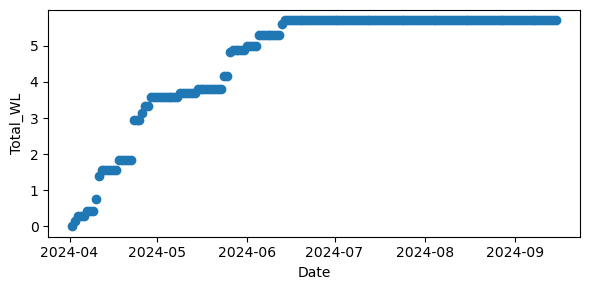

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 3))

# First plot for Total_ET vs Total_ET_ref
ax1.set_xlabel('Date')
ax1.set_ylabel('Total_WL')
ax1.scatter(dat['Date'], dat['Total_WL'])



# Adjust layout and show the plot
plt.tight_layout()
plt.show()